# 📊 STOCK ANALYSIS DASHBOARD

**Dashboard tổng quát thực tiễn cho phân tích cổ phiếu VN & Mỹ**

---

## 🎯 Mục tiêu
- **Tổng quan**: Thống kê tổng hợp và xu hướng thị trường
- **Top performers**: Cổ phiếu tăng/giảm nhiều nhất
- **So sánh**: Risk-Return giữa VN và Mỹ
- **Monitoring**: Trạng thái pipeline và chất lượng dữ liệu


In [23]:
# 📦 IMPORTS & SETUP
import psycopg2
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime, timedelta
import warnings

# Suppress ALL warnings
warnings.filterwarnings('ignore')

# Kết nối database
conn = psycopg2.connect(
    host='postgres',
    database='realdata_warehouse',
    user='postgres', 
    password='postgres',
    port='5432'
)

print(f"✅ Kết nối thành công - {datetime.now().strftime('%H:%M:%S')}")


✅ Kết nối thành công - 17:07:23


📈 TỔNG QUAN THỊ TRƯỜNG:
             market  records  symbols  avg_price  avg_return  volatility  avg_volume start_date   end_date
      Thị trường Mỹ     3838      767     199.02       -0.12        2.33 35296975.94 2025-08-01 2025-11-03
Thị trường Việt Nam     1195       52   46834.63       -0.00        2.42 10186171.31 2025-09-23 2025-10-23


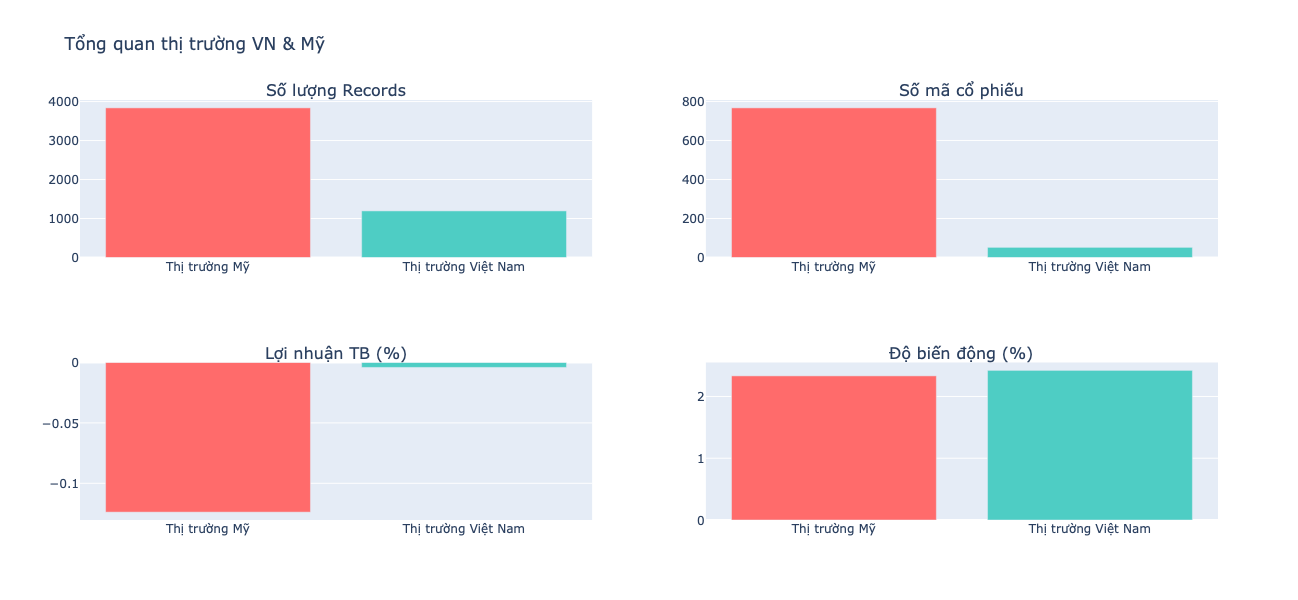

In [ ]:
# 📊 1. TỔNG QUAN THỊ TRƯỜNG
def get_market_overview():
    query = """
    SELECT 
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END as market,
        COUNT(*) as records,
        COUNT(DISTINCT symbol) as symbols,
        AVG(close_price) as avg_price,
        AVG(daily_return) as avg_return,
        STDDEV(daily_return) as volatility,
        AVG(volume) as avg_volume,
        MIN(date) as start_date,
        MAX(date) as end_date
    FROM stocks.stocks_daily_all
    WHERE daily_return IS NOT NULL
    GROUP BY 
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END
    ORDER BY records DESC
    """
    return pd.read_sql(query, conn)

df_overview = get_market_overview()
print("📈 TỔNG QUAN THỊ TRƯỜNG:")
print(df_overview.round(2).to_string(index=False))

# Biểu đồ tổng quan
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Số lượng Records', 'Số mã cổ phiếu', 'Lợi nhuận TB (%)', 'Độ biến động (%)'),
    specs=[[{"type": "bar"}, {"type": "bar"}], [{"type": "bar"}, {"type": "bar"}]]
)

colors = ['#FF6B6B', '#4ECDC4']
fig.add_trace(go.Bar(x=df_overview['market'], y=df_overview['records'], name='Records', marker_color=colors), row=1, col=1)
fig.add_trace(go.Bar(x=df_overview['market'], y=df_overview['symbols'], name='Symbols', marker_color=colors), row=1, col=2)
fig.add_trace(go.Bar(x=df_overview['market'], y=df_overview['avg_return'], name='Avg Return', marker_color=colors), row=2, col=1)
fig.add_trace(go.Bar(x=df_overview['market'], y=df_overview['volatility'], name='Volatility', marker_color=colors), row=2, col=2)

fig.update_layout(height=600, title_text="Tổng quan thị trường VN & Mỹ", showlegend=False)
fig.show()


🚀 TOP 15 CỔ PHIẾU TĂNG NHIỀU NHẤT:
symbol              market  total_return  avg_return  volatility  trading_days
   VRE Thị trường Việt Nam         34.88        1.52        3.76            23
   VJC Thị trường Việt Nam         33.58        1.46        2.89            23
   VIC Thị trường Việt Nam         32.13        1.40        3.22            23
   CAT       Thị trường Mỹ         26.00        0.48        2.38            54
  NFLX       Thị trường Mỹ         22.59        0.40        1.89            56
   JPM       Thị trường Mỹ         22.07        0.33        1.37            66
   CII Thị trường Việt Nam         20.30        0.88        3.93            23
   XOM       Thị trường Mỹ         17.45        0.26        1.45            66
   HDB Thị trường Việt Nam         14.96        0.65        2.96            23
   VHM Thị trường Việt Nam         14.74        0.64        3.27            23
  NVDA       Thị trường Mỹ         12.11        0.18        1.81            66
  AMZN       Thị 

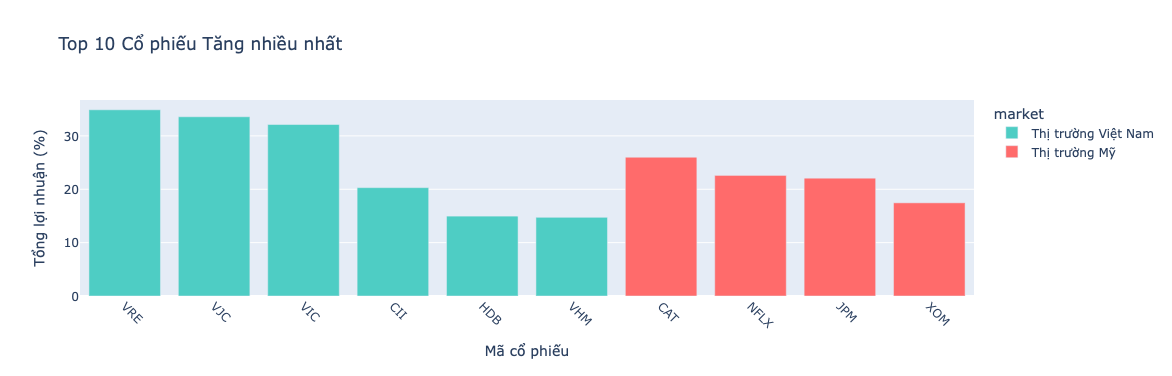

In [ ]:
# 🏆 2. TOP PERFORMERS - TĂNG NHIỀU NHẤT
def get_top_gainers(limit=10):
    query = f"""
    SELECT 
        symbol,
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END as market,
        COUNT(*) as trading_days,
        AVG(daily_return) as avg_return,
        SUM(daily_return) as total_return,
        STDDEV(daily_return) as volatility,
        AVG(volume) as avg_volume,
        MAX(daily_return) as best_day,
        MIN(daily_return) as worst_day
    FROM stocks.stocks_daily_all
    WHERE daily_return IS NOT NULL
    GROUP BY symbol, 
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END
    HAVING COUNT(*) >= 5
    ORDER BY total_return DESC
    LIMIT {limit}
    """
    return pd.read_sql(query, conn)

df_top_gainers = get_top_gainers(15)
print("🚀 TOP 15 CỔ PHIẾU TĂNG NHIỀU NHẤT:")
print(df_top_gainers[['symbol', 'market', 'total_return', 'avg_return', 'volatility', 'trading_days']].round(2).to_string(index=False))

# Biểu đồ top gainers
fig = px.bar(df_top_gainers.head(10), x='symbol', y='total_return', color='market',
             title='Top 10 Cổ phiếu Tăng nhiều nhất',
             labels={'total_return': 'Tổng lợi nhuận (%)', 'symbol': 'Mã cổ phiếu'},
             color_discrete_map={'Thị trường Mỹ': '#FF6B6B', 'Thị trường Việt Nam': '#4ECDC4'})

fig.update_layout(xaxis_tickangle=45, height=500)
fig.show()


📉 TOP 15 CỔ PHIẾU GIẢM NHIỀU NHẤT:
symbol              market  total_return  avg_return  volatility  trading_days
   NKE       Thị trường Mỹ        -31.72       -1.32        1.39            24
   VGC Thị trường Việt Nam        -23.08       -1.00        2.63            23
   UNH       Thị trường Mỹ        -22.28       -0.37        1.99            61
   IWM       Thị trường Mỹ        -17.50       -0.32        1.58            54
   DXS Thị trường Việt Nam        -16.29       -0.71        3.37            23
    PG       Thị trường Mỹ        -15.58       -0.28        1.43            56
  ADBE       Thị trường Mỹ        -14.15       -2.83        2.59             5
  INTC       Thị trường Mỹ        -12.98       -2.16        2.21             6
    BA       Thị trường Mỹ        -12.22       -0.23        1.83            54
   VCI Thị trường Việt Nam        -12.17       -0.53        2.66            23
   DXG Thị trường Việt Nam        -12.13       -0.53        3.49            23
    HD       Thị 

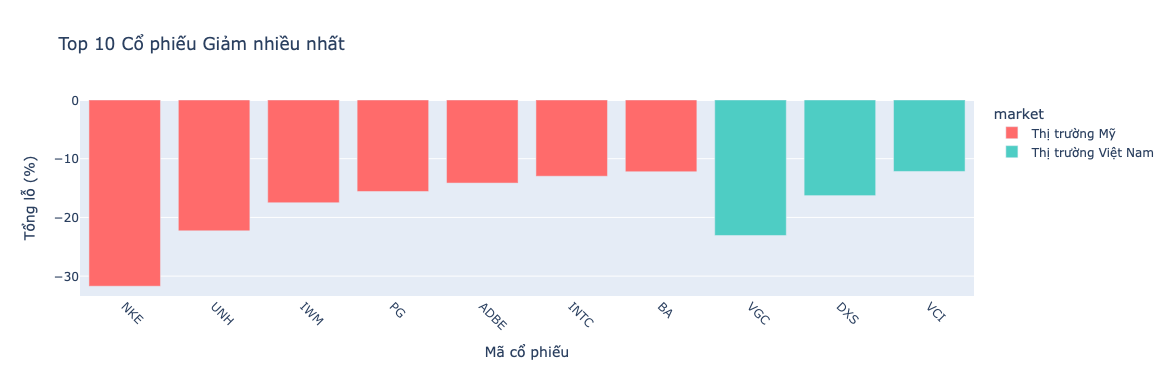

In [ ]:
# 📉 3. TOP LOSERS - GIẢM NHIỀU NHẤT
def get_top_losers(limit=10):
    query = f"""
    SELECT 
        symbol,
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END as market,
        COUNT(*) as trading_days,
        AVG(daily_return) as avg_return,
        SUM(daily_return) as total_return,
        STDDEV(daily_return) as volatility,
        AVG(volume) as avg_volume,
        MAX(daily_return) as best_day,
        MIN(daily_return) as worst_day
    FROM stocks.stocks_daily_all
    WHERE daily_return IS NOT NULL
    GROUP BY symbol, 
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END
    HAVING COUNT(*) >= 5
    ORDER BY total_return ASC
    LIMIT {limit}
    """
    return pd.read_sql(query, conn)

df_top_losers = get_top_losers(15)
print("📉 TOP 15 CỔ PHIẾU GIẢM NHIỀU NHẤT:")
print(df_top_losers[['symbol', 'market', 'total_return', 'avg_return', 'volatility', 'trading_days']].round(2).to_string(index=False))

# Biểu đồ top losers
fig = px.bar(df_top_losers.head(10), x='symbol', y='total_return', color='market',
             title='Top 10 Cổ phiếu Giảm nhiều nhất',
             labels={'total_return': 'Tổng lỗ (%)', 'symbol': 'Mã cổ phiếu'},
             color_discrete_map={'Thị trường Mỹ': '#FF6B6B', 'Thị trường Việt Nam': '#4ECDC4'})

fig.update_layout(xaxis_tickangle=45, height=500)
fig.show()


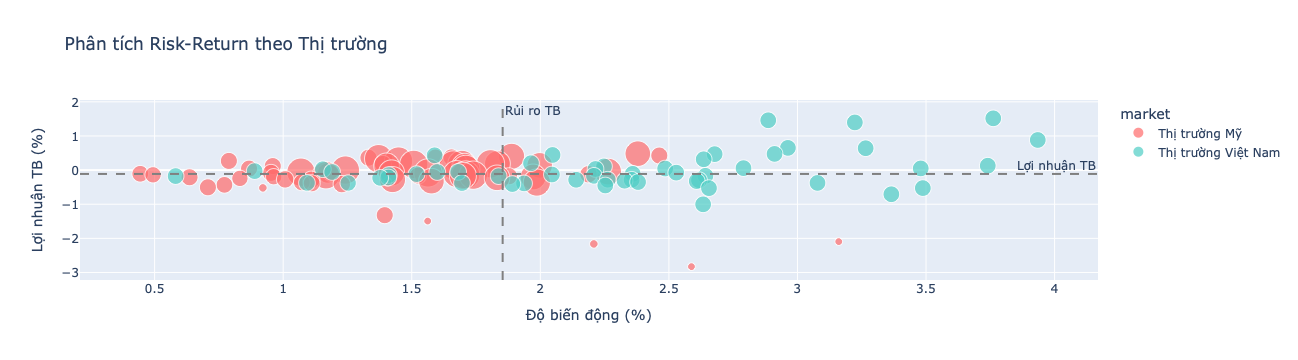


📊 THỐNG KÊ RISK-RETURN:
                    avg_return        volatility        symbol
                          mean    std       mean    std  count
market                                                        
Thị trường Mỹ           -0.204  0.603      1.484  0.528     62
Thị trường Việt Nam     -0.004  0.507      2.294  0.781     52


In [ ]:
# ⚖️ 4. RISK-RETURN ANALYSIS
def get_risk_return_data():
    query = """
    SELECT 
        symbol,
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END as market,
        COUNT(*) as trading_days,
        AVG(daily_return) as avg_return,
        STDDEV(daily_return) as volatility,
        AVG(volume) as avg_volume
    FROM stocks.stocks_daily_all
    WHERE daily_return IS NOT NULL
    GROUP BY symbol, 
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END
    HAVING COUNT(*) >= 5
    ORDER BY market, avg_return DESC
    """
    return pd.read_sql(query, conn)

df_risk_return = get_risk_return_data()

# Scatter plot Risk-Return
fig = px.scatter(df_risk_return, x='volatility', y='avg_return', 
                 color='market', size='trading_days',
                 title='Phân tích Risk-Return theo Thị trường',
                 labels={'volatility': 'Độ biến động (%)', 'avg_return': 'Lợi nhuận TB (%)'},
                 color_discrete_map={'Thị trường Mỹ': '#FF6B6B', 'Thị trường Việt Nam': '#4ECDC4'})

# Thêm đường trung bình
fig.add_hline(y=df_risk_return['avg_return'].mean(), line_dash="dash", line_color="gray",
              annotation_text="Lợi nhuận TB")
fig.add_vline(x=df_risk_return['volatility'].mean(), line_dash="dash", line_color="gray",
              annotation_text="Rủi ro TB")

fig.show()

# Thống kê Risk-Return
print("\n📊 THỐNG KÊ RISK-RETURN:")
stats = df_risk_return.groupby('market').agg({
    'avg_return': ['mean', 'std'],
    'volatility': ['mean', 'std'],
    'symbol': 'count'
}).round(3)
print(stats)


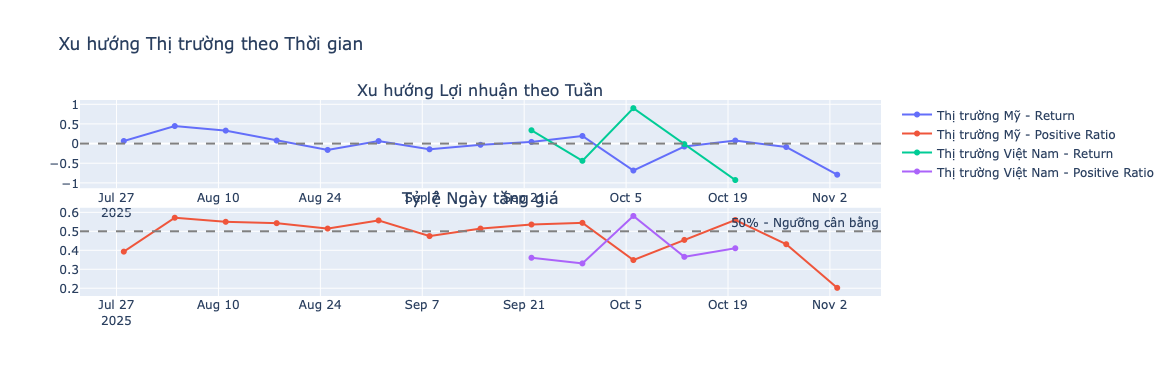


📅 XU HƯỚNG GẦN NHẤT:
             market                      week  avg_return  positive_ratio
      Thị trường Mỹ 2025-11-03 00:00:00+00:00      -0.792           0.202
Thị trường Việt Nam 2025-10-20 00:00:00+00:00      -0.928           0.411


In [ ]:
# 📈 5. TIME SERIES TRENDS
def get_time_series_data():
    query = """
    SELECT 
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END as market,
        DATE_TRUNC('week', date) as week,
        COUNT(*) as records,
        AVG(daily_return) as avg_return,
        STDDEV(daily_return) as volatility,
        SUM(CASE WHEN daily_return > 0 THEN 1 ELSE 0 END) as positive_days,
        COUNT(*) as total_days
    FROM stocks.stocks_daily_all
    WHERE daily_return IS NOT NULL
    GROUP BY 
        CASE 
            WHEN source IN ('finnhub', 'alphavantage', 'polygon') THEN 'Thị trường Mỹ'
            WHEN source = 'yahoo' THEN 'Thị trường Việt Nam'
            ELSE 'Khác'
        END,
        DATE_TRUNC('week', date)
    ORDER BY market, week
    """
    return pd.read_sql(query, conn)

df_trends = get_time_series_data()
df_trends['positive_ratio'] = df_trends['positive_days'] / df_trends['total_days']

# Biểu đồ xu hướng
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Xu hướng Lợi nhuận theo Tuần', 'Tỷ lệ Ngày tăng giá'),
    vertical_spacing=0.1
)

for market in df_trends['market'].unique():
    market_data = df_trends[df_trends['market'] == market]
    fig.add_trace(go.Scatter(x=market_data['week'], y=market_data['avg_return'], 
                            name=f'{market} - Return', mode='lines+markers'), row=1, col=1)
    fig.add_trace(go.Scatter(x=market_data['week'], y=market_data['positive_ratio'], 
                            name=f'{market} - Positive Ratio', mode='lines+markers'), row=2, col=1)

fig.add_hline(y=0, line_dash="dash", line_color="gray", row=1, col=1)
fig.add_hline(y=0.5, line_dash="dash", line_color="gray", row=2, col=1, 
              annotation_text="50% - Ngưỡng cân bằng")

fig.update_layout(height=700, title_text="Xu hướng Thị trường theo Thời gian")
fig.show()

print("\n📅 XU HƯỚNG GẦN NHẤT:")
latest = df_trends.groupby('market').tail(1)[['market', 'week', 'avg_return', 'positive_ratio']]
print(latest.round(3).to_string(index=False))


📊 CANDLESTICK ANALYSIS:
• Top US: CAT
• Top VN: VRE


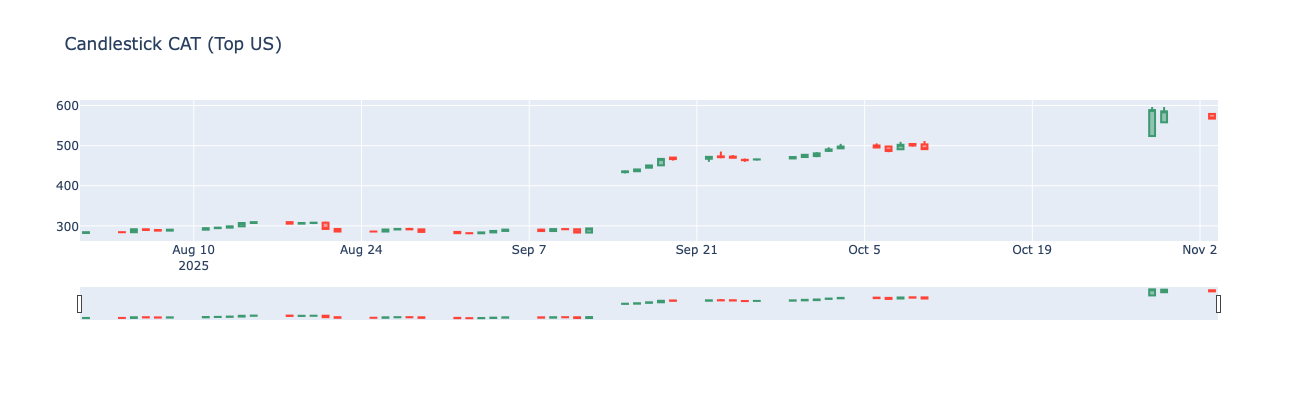

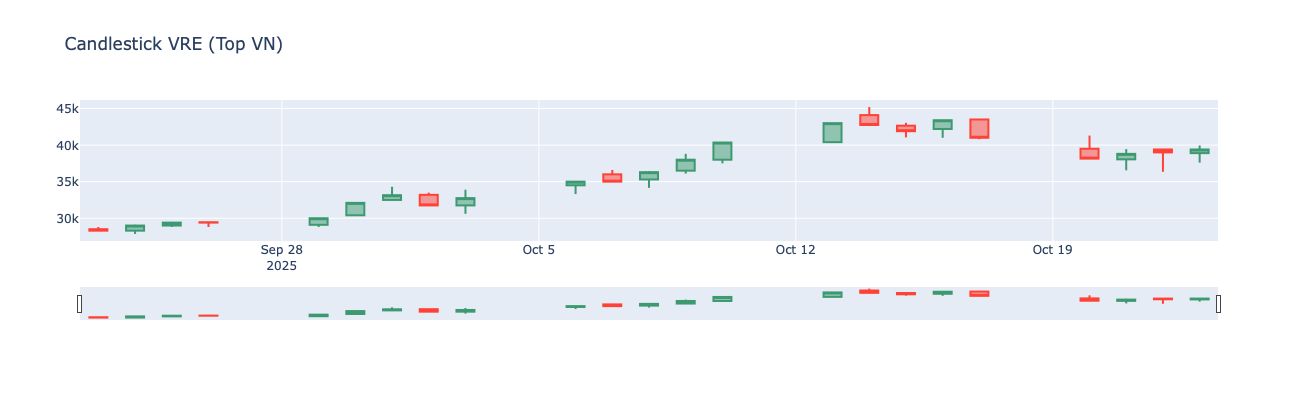

In [ ]:
# 🔍 6. CANDLESTICK ANALYSIS (Top performer mỗi thị trường)
def get_candlestick_data(symbol, market_type):
    if market_type == 'Thị trường Mỹ':
        source_filter = "source IN ('finnhub', 'alphavantage', 'polygon')"
    else:
        source_filter = "source = 'yahoo'"
    
    query = f"""
    SELECT date, open_price, high_price, low_price, close_price, volume, daily_return
    FROM stocks.stocks_daily_all
    WHERE symbol = '{symbol}' AND {source_filter}
    ORDER BY date
    """
    return pd.read_sql(query, conn)

# Tìm top performer mỗi thị trường
top_us = df_top_gainers[df_top_gainers['market'] == 'Thị trường Mỹ'].iloc[0]['symbol']
top_vn = df_top_gainers[df_top_gainers['market'] == 'Thị trường Việt Nam'].iloc[0]['symbol']

print(f"📊 CANDLESTICK ANALYSIS:")
print(f"• Top US: {top_us}")
print(f"• Top VN: {top_vn}")

# Candlestick cho top US
df_us_candle = get_candlestick_data(top_us, 'Thị trường Mỹ')
if not df_us_candle.empty:
    fig = go.Figure(data=go.Candlestick(
        x=df_us_candle['date'],
        open=df_us_candle['open_price'],
        high=df_us_candle['high_price'],
        low=df_us_candle['low_price'],
        close=df_us_candle['close_price'],
        name=top_us
    ))
    fig.update_layout(title=f'Candlestick {top_us} (Top US)', height=400)
    fig.show()

# Candlestick cho top VN
df_vn_candle = get_candlestick_data(top_vn, 'Thị trường Việt Nam')
if not df_vn_candle.empty:
    fig = go.Figure(data=go.Candlestick(
        x=df_vn_candle['date'],
        open=df_vn_candle['open_price'],
        high=df_vn_candle['high_price'],
        low=df_vn_candle['low_price'],
        close=df_vn_candle['close_price'],
        name=top_vn
    ))
    fig.update_layout(title=f'Candlestick {top_vn} (Top VN)', height=400)
    fig.show()


🏭 PHÂN TÍCH THEO NGÀNH - THỊ TRƯỜNG MỸ

📊 Tổng số ngành: 37

📈 TOP 10 NGÀNH TỐT NHẤT (theo lợi nhuận TB):
                        sector  stock_count  avg_return  volatility  positive_days_pct
    Logistics & Transportation            5        1.37        0.70             100.00
                        Energy           40        1.09        3.47              62.79
                     Machinery           27        0.93        3.53              45.28
             Telecommunication            6        0.78        5.44              43.75
                 Biotechnology           49        0.59        3.96              43.88
                  Construction            6        0.55        1.68              55.56
Life Sciences Tools & Services            8        0.55        4.40              41.18
                   Road & Rail            7        0.07        1.67              53.85
                Semiconductors           16        0.03        2.86              40.00
                   Healt

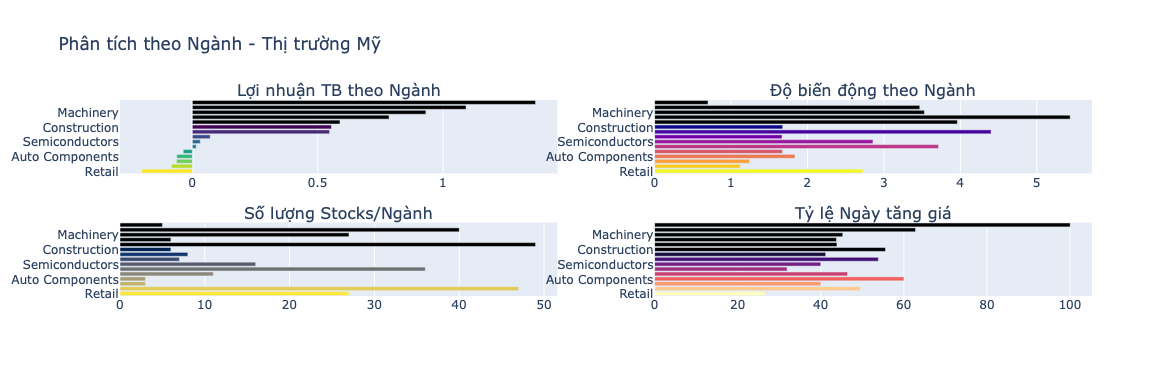

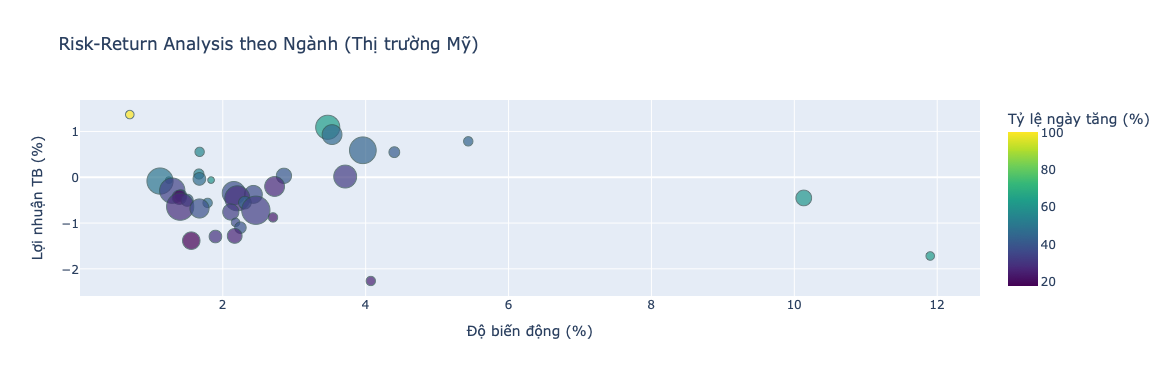

In [ ]:
# 🏭 7. PHÂN TÍCH THEO NGÀNH - THỊ TRƯỜNG MỸ
def get_sector_analysis_us():
    """Phân tích theo sector cho thị trường Mỹ (Finnhub có sector data)"""
    query = """
    SELECT 
        sector,
        COUNT(DISTINCT symbol) as stock_count,
        COUNT(*) as total_records,
        AVG(daily_return) as avg_return,
        STDDEV(daily_return) as volatility,
        SUM(daily_return) as total_return,
        AVG(close_price) as avg_price,
        MAX(daily_return) as best_day_return,
        MIN(daily_return) as worst_day_return,
        SUM(CASE WHEN daily_return > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) as positive_days_pct
    FROM stocks.stocks_daily_all
    WHERE source IN ('finnhub', 'alphavantage', 'polygon')
        AND sector IS NOT NULL
        AND sector != ''
        AND daily_return IS NOT NULL
    GROUP BY sector
    HAVING COUNT(DISTINCT symbol) >= 3  -- Ít nhất 3 stocks trong sector
    ORDER BY avg_return DESC
    """
    return pd.read_sql(query, conn)

df_sector_us = get_sector_analysis_us()

print("🏭 PHÂN TÍCH THEO NGÀNH - THỊ TRƯỜNG MỸ")
print("=" * 60)
if not df_sector_us.empty:
    print(f"\n📊 Tổng số ngành: {len(df_sector_us)}")
    print(f"\n📈 TOP 10 NGÀNH TỐT NHẤT (theo lợi nhuận TB):")
    top_sectors = df_sector_us.head(10)[['sector', 'stock_count', 'avg_return', 'volatility', 'positive_days_pct']]
    print(top_sectors.round(2).to_string(index=False))
    
    print(f"\n📉 TOP 10 NGÀNH YẾU NHẤT (theo lợi nhuận TB):")
    worst_sectors = df_sector_us.tail(10)[['sector', 'stock_count', 'avg_return', 'volatility', 'positive_days_pct']]
    print(worst_sectors.round(2).to_string(index=False))
    
    # Biểu đồ sector performance
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Lợi nhuận TB theo Ngành', 'Độ biến động theo Ngành', 
                       'Số lượng Stocks/Ngành', 'Tỷ lệ Ngày tăng giá'),
        specs=[[{"type": "bar"}, {"type": "bar"}], [{"type": "bar"}, {"type": "bar"}]]
    )
    
    # Lấy top 15 sectors để visualize
    top_15 = df_sector_us.head(15).sort_values('avg_return', ascending=True)
    
    # Avg Return
    fig.add_trace(go.Bar(x=top_15['avg_return'], y=top_15['sector'], 
                         orientation='h', name='Avg Return', 
                         marker_color=px.colors.sequential.Viridis_r[:len(top_15)]), 
                 row=1, col=1)
    
    # Volatility
    fig.add_trace(go.Bar(x=top_15['volatility'], y=top_15['sector'], 
                         orientation='h', name='Volatility',
                         marker_color=px.colors.sequential.Plasma_r[:len(top_15)]), 
                 row=1, col=2)
    
    # Stock Count
    fig.add_trace(go.Bar(x=top_15['stock_count'], y=top_15['sector'], 
                         orientation='h', name='Stock Count',
                         marker_color=px.colors.sequential.Cividis_r[:len(top_15)]), 
                 row=2, col=1)
    
    # Positive Days %
    fig.add_trace(go.Bar(x=top_15['positive_days_pct'], y=top_15['sector'], 
                         orientation='h', name='Positive Days %',
                         marker_color=px.colors.sequential.Magma_r[:len(top_15)]), 
                 row=2, col=2)
    
    fig.update_layout(height=800, title_text="Phân tích theo Ngành - Thị trường Mỹ", showlegend=False)
    fig.show()
    
    # Scatter plot Risk-Return by Sector
    fig2 = px.scatter(df_sector_us, x='volatility', y='avg_return', 
                     size='stock_count', color='positive_days_pct',
                     hover_data=['sector', 'total_return'],
                     title='Risk-Return Analysis theo Ngành (Thị trường Mỹ)',
                     labels={'volatility': 'Độ biến động (%)', 
                            'avg_return': 'Lợi nhuận TB (%)',
                            'stock_count': 'Số stocks',
                            'positive_days_pct': 'Tỷ lệ ngày tăng (%)'},
                     color_continuous_scale='Viridis')
    
    fig2.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
    fig2.update_layout(height=600)
    fig2.show()
else:
    print("⚠️ Không có dữ liệu sector cho thị trường Mỹ")


🔧 TRẠNG THÁI PIPELINE:
• Pipeline: ✅ BẬT
• VN Flow: ❌ TẮT
• US Source: alphavantage
• Schedule: 0 22 * * 1-5
• DAGs: 2
• Failed 24h: 6
• Connections: 58


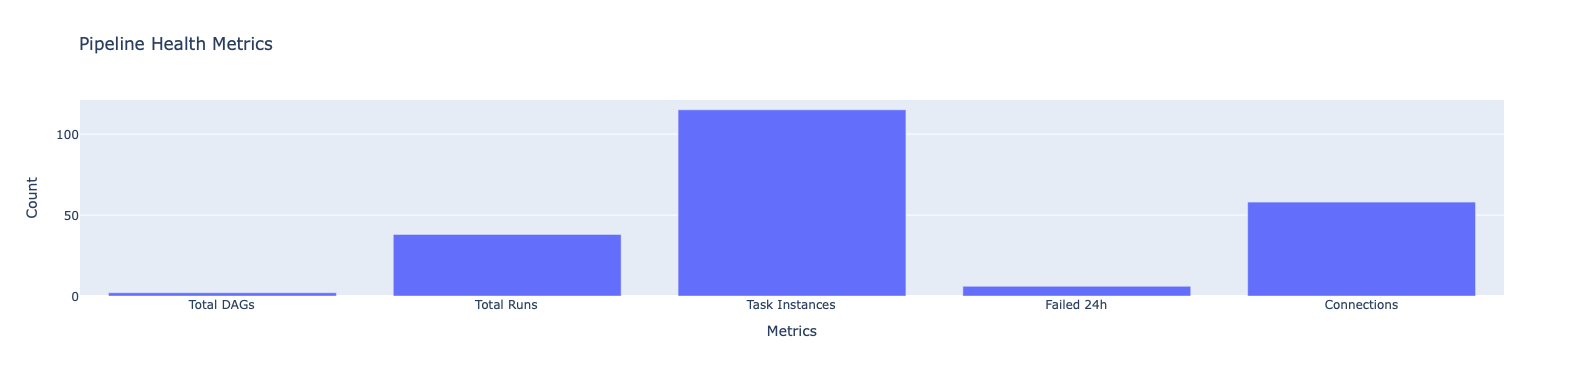

In [ ]:
# 📊 8. PIPELINE MONITORING
def get_pipeline_status():
    query = """
    SELECT * FROM public.project_meta_overview
    """
    return pd.read_sql(query, conn)

df_pipeline = get_pipeline_status()
print("🔧 TRẠNG THÁI PIPELINE:")
print(f"• Pipeline: {'✅ BẬT' if df_pipeline['pipeline_enabled'].iloc[0] else '❌ TẮT'}")
print(f"• VN Flow: {'✅ BẬT' if df_pipeline['vn_flow_enabled'].iloc[0] else '❌ TẮT'}")
print(f"• US Source: {df_pipeline['us_flow_primary'].iloc[0]}")
print(f"• Schedule: {df_pipeline['schedule_cron'].iloc[0]}")
print(f"• DAGs: {df_pipeline['total_dags'].iloc[0]}")
print(f"• Failed 24h: {df_pipeline['failed_tasks_24h'].iloc[0]}")
print(f"• Connections: {df_pipeline['connections'].iloc[0]}")

# Biểu đồ pipeline health
health_data = {
    'Metric': ['Total DAGs', 'Total Runs', 'Task Instances', 'Failed 24h', 'Connections'],
    'Value': [df_pipeline['total_dags'].iloc[0], df_pipeline['total_dag_runs'].iloc[0], 
              df_pipeline['total_task_instances'].iloc[0], df_pipeline['failed_tasks_24h'].iloc[0],
              df_pipeline['connections'].iloc[0]]
}

fig = px.bar(x=health_data['Metric'], y=health_data['Value'], 
             title='Pipeline Health Metrics',
             labels={'x': 'Metrics', 'y': 'Count'})
fig.update_layout(height=400)
fig.show()


In [32]:
# 🎯 9. SUMMARY & INSIGHTS
print("🎯 TÓM TẮT & INSIGHTS:")
print("=" * 50)

# Market comparison
us_market = df_overview[df_overview['market'] == 'Thị trường Mỹ']
vn_market = df_overview[df_overview['market'] == 'Thị trường Việt Nam']

if not us_market.empty and not vn_market.empty:
    print(f"📊 QUY MÔ THỊ TRƯỜNG:")
    print(f"   • Mỹ: {us_market['records'].iloc[0]:,} records, {us_market['symbols'].iloc[0]} mã")
    print(f"   • VN: {vn_market['records'].iloc[0]:,} records, {vn_market['symbols'].iloc[0]} mã")
    
    print(f"\n💰 HIỆU SUẤT:")
    print(f"   • Mỹ: {us_market['avg_return'].iloc[0]:.2f}% (vol: {us_market['volatility'].iloc[0]:.2f}%)")
    print(f"   • VN: {vn_market['avg_return'].iloc[0]:.2f}% (vol: {vn_market['volatility'].iloc[0]:.2f}%)")
    
    print(f"\n🚀 TOP GAINERS:")
    print(f"   • Mỹ: {top_us} ({df_top_gainers[df_top_gainers['symbol']==top_us]['total_return'].iloc[0]:.2f}%)")
    print(f"   • VN: {top_vn} ({df_top_gainers[df_top_gainers['symbol']==top_vn]['total_return'].iloc[0]:.2f}%)")
    
    print(f"\n📉 TOP LOSERS:")
    worst_us = df_top_losers[df_top_losers['market'] == 'Thị trường Mỹ'].iloc[0]['symbol']
    worst_vn = df_top_losers[df_top_losers['market'] == 'Thị trường Việt Nam'].iloc[0]['symbol']
    print(f"   • Mỹ: {worst_us} ({df_top_losers[df_top_losers['symbol']==worst_us]['total_return'].iloc[0]:.2f}%)")
    print(f"   • VN: {worst_vn} ({df_top_losers[df_top_losers['symbol']==worst_vn]['total_return'].iloc[0]:.2f}%)")
    
    print(f"\n💡 KHUYẾN NGHỊ:")
    if us_market['avg_return'].iloc[0] > vn_market['avg_return'].iloc[0]:
        print(f"   • Thị trường Mỹ có lợi nhuận cao hơn")
    else:
        print(f"   • Thị trường VN có lợi nhuận cao hơn")
        
    if us_market['volatility'].iloc[0] > vn_market['volatility'].iloc[0]:
        print(f"   • Thị trường Mỹ có rủi ro cao hơn")
    else:
        print(f"   • Thị trường VN có rủi ro cao hơn")
    
    print(f"   • Đa dạng hóa đầu tư giữa 2 thị trường")
    print(f"   • Theo dõi xu hướng dài hạn")

# Pipeline status
print(f"\n🔧 PIPELINE STATUS:")
if df_pipeline['failed_tasks_24h'].iloc[0] == 0:
    print(f"   ✅ Pipeline hoạt động tốt (0 lỗi 24h)")
else:
    print(f"   ⚠️ Có {df_pipeline['failed_tasks_24h'].iloc[0]} lỗi trong 24h - cần kiểm tra")

print(f"\n⏰ Cập nhật: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Đóng kết nối
conn.close()
print("\n✅ Hoàn thành phân tích!")


🎯 TÓM TẮT & INSIGHTS:
📊 QUY MÔ THỊ TRƯỜNG:
   • Mỹ: 3,838 records, 767 mã
   • VN: 1,195 records, 52 mã

💰 HIỆU SUẤT:
   • Mỹ: -0.12% (vol: 2.33%)
   • VN: -0.00% (vol: 2.42%)

🚀 TOP GAINERS:
   • Mỹ: CAT (26.00%)
   • VN: VRE (34.88%)

📉 TOP LOSERS:
   • Mỹ: NKE (-31.72%)
   • VN: VGC (-23.08%)

💡 KHUYẾN NGHỊ:
   • Thị trường VN có lợi nhuận cao hơn
   • Thị trường VN có rủi ro cao hơn
   • Đa dạng hóa đầu tư giữa 2 thị trường
   • Theo dõi xu hướng dài hạn

🔧 PIPELINE STATUS:
   ⚠️ Có 6 lỗi trong 24h - cần kiểm tra

⏰ Cập nhật: 2025-11-03 17:07:28

✅ Hoàn thành phân tích!
